In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from IPython.display import clear_output as clear

!pip install fastai==2.0.13

# clear()

In [3]:
from fastai.vision.all import *

/usr/local/lib/python3.6/dist-packages/fastcore/foundation.py:54: UserWarning: `patch_property` is deprecated and will be removed; use `patch(as_prop=True)` instead
  warnings.warn("`patch_property` is deprecated and will be removed; use `patch(as_prop=True)` instead")


In [4]:
path = untar_data(URLs.PETS)
path

Path('/root/.fastai/data/oxford-iiit-pet')

In [5]:
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [6]:
path_anno = path/'annotation'
path_img = path/'images'

In [7]:
fnames = get_image_files(path_img)
fnames[:2]

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_141.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_3.jpg')]

In [9]:
pets = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=2020),
    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)
dls = pets.dataloaders(path_img)

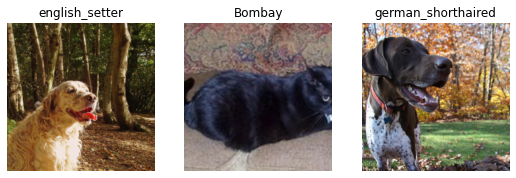

In [10]:
dls.show_batch(nrows=1, ncols=3)

In [11]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [12]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.949018,0.303280,0.095399,01:04
1,0.712842,0.200311,0.066306,01:04
2,0.433919,0.192648,0.068336,01:04
3,0.342701,0.185246,0.065629,01:04


In [13]:
learn.save('stage-1')  # 保存模型

Path('models/stage-1.pth')

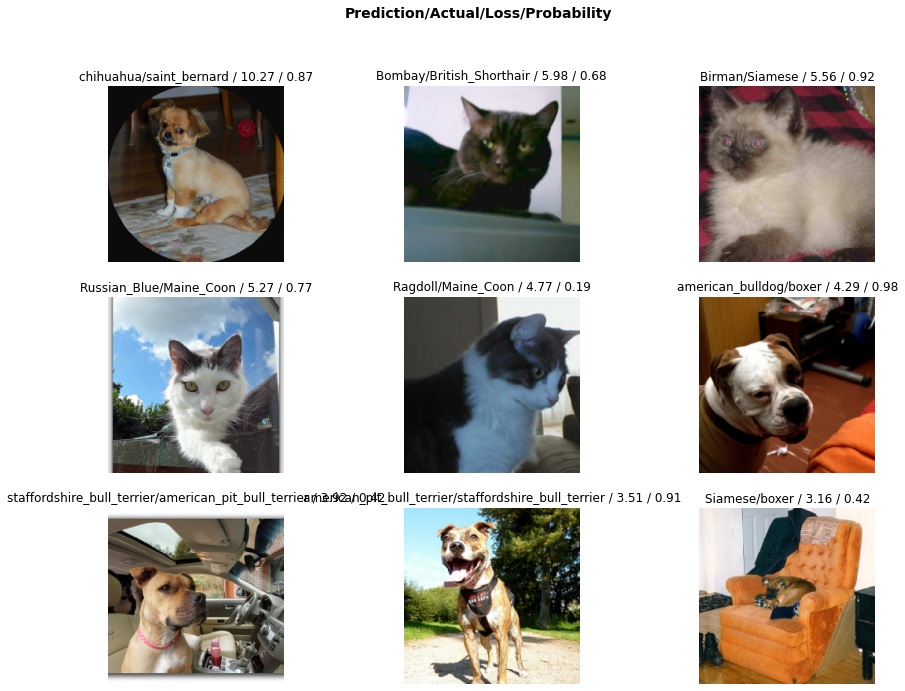

In [14]:
# 首先查看模型出错率最高的是哪个类别，即分析错误的case
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15, 11))

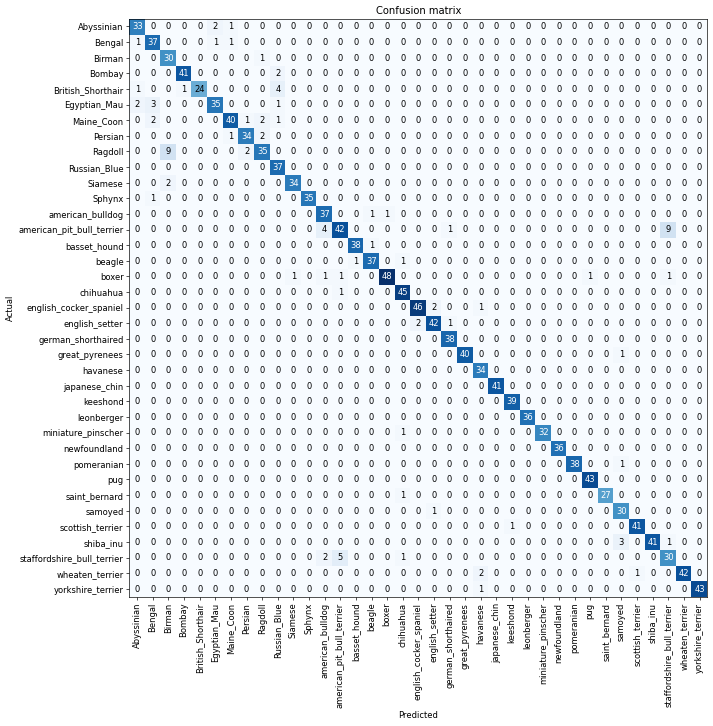

In [15]:
# 查看混淆矩阵
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [16]:
interp.most_confused(min_val=2)

[('Ragdoll', 'Birman', 9),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 9),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5),
 ('British_Shorthair', 'Russian_Blue', 4),
 ('american_pit_bull_terrier', 'american_bulldog', 4),
 ('Egyptian_Mau', 'Bengal', 3),
 ('shiba_inu', 'samoyed', 3),
 ('Abyssinian', 'Egyptian_Mau', 2),
 ('Bombay', 'Russian_Blue', 2),
 ('Egyptian_Mau', 'Abyssinian', 2),
 ('Maine_Coon', 'Bengal', 2),
 ('Maine_Coon', 'Ragdoll', 2),
 ('Persian', 'Ragdoll', 2),
 ('Ragdoll', 'Persian', 2),
 ('Siamese', 'Birman', 2),
 ('english_cocker_spaniel', 'english_setter', 2),
 ('english_setter', 'english_cocker_spaniel', 2),
 ('staffordshire_bull_terrier', 'american_bulldog', 2),
 ('wheaten_terrier', 'havanese', 2)]

In [17]:
# Unfreezing and fine-tuning
learn.unfreeze()
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.344759,0.657820,0.213126,01:07


SuggestedLRs(lr_min=1.3182566908653825e-05, lr_steep=2.75422871709452e-06)

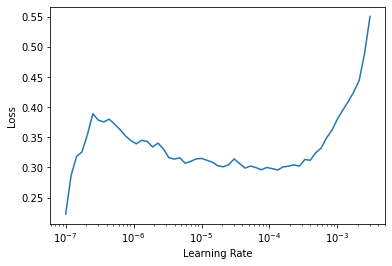

In [19]:
# 尝试调整学习率
learn.load('stage-1')
learn.lr_find()

In [20]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.540053,2.696967,0.590663,01:07
1,0.865300,0.430731,0.146143,01:07


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0014454397605732083)

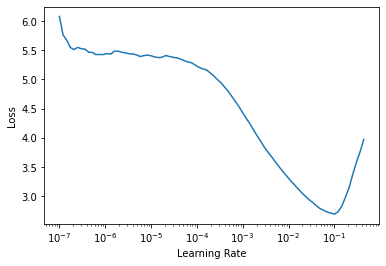

In [21]:
# 使用更复杂的网络测试

learn = cnn_learner(dls, resnet50, metrics=error_rate)
learn.lr_find()

In [22]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.530442,0.300067,0.094723,01:12
1,0.595795,0.272372,0.095399,01:12
2,0.385314,0.208974,0.075101,01:11
3,0.288230,0.198083,0.064276,01:12
4,0.210291,0.176853,0.056834,01:12
5,0.166485,0.158083,0.054127,01:12
6,0.125077,0.161648,0.050068,01:12
7,0.118253,0.154648,0.050744,01:12


In [23]:
learn.save('stage-2')  # 保存模型之后，可以随时回档

Path('models/stage-2.pth')

In [24]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.530342,3.310850,0.646143,01:21
1,1.042027,0.608217,0.200271,01:20
2,0.536945,0.342382,0.113667,01:20


In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('Ragdoll', 'Birman', 11),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 8),
 ('english_cocker_spaniel', 'english_setter', 7),
 ('Maine_Coon', 'Ragdoll', 5),
 ('beagle', 'basset_hound', 5),
 ('english_setter', 'english_cocker_spaniel', 5),
 ('staffordshire_bull_terrier', 'american_bulldog', 5),
 ('Bengal', 'Egyptian_Mau', 4),
 ('chihuahua', 'miniature_pinscher', 4),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 4),
 ('Russian_Blue', 'British_Shorthair', 3),
 ('american_bulldog', 'saint_bernard', 3),
 ('Egyptian_Mau', 'Abyssinian', 2),
 ('Egyptian_Mau', 'Bengal', 2),
 ('Maine_Coon', 'Persian', 2),
 ('Persian', 'Ragdoll', 2),
 ('Siamese', 'Birman', 2),
 ('american_bulldog', 'basset_hound', 2),
 ('american_bulldog', 'beagle', 2),
 ('american_pit_bull_terrier', 'american_bulldog', 2),
 ('beagle', 'shiba_inu', 2),
 ('boxer', 'beagle', 2),
 ('boxer', 'pug', 2),
 ('chihuahua', 'Sphynx', 2),
 ('chihuahua', 'shiba_inu', 2),
 ('english_cocker_spaniel', 'yorkshire_t